In [1]:
import numpy as np
import shapely
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rasterio.windows  as rw
from rasterio.enums import Resampling
from rasterio.transform import Affine
from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
from matplotlib_scalebar.scalebar import ScaleBar
from typing import List, Any
import os
import pyproj
import pandas as pd
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as img
import cmocean
import cmocean.cm as cmo

import sgl_processor_v03 as sgl
import sgl_utils
import geopandas as gpd

In [7]:
import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd

settings18 = sgl.ProcessorSGLSettings.from_range("20181201", "20190331")
sgl.initialize(settings18)
metas18 = sgl.get_metadata_from_csv(settings18.season_folder, ["tile-181", "tile-182", "tile-183"])
coll18 = sgl.create_collection_from_meta(settings18, metas18)

settings19 = sgl.ProcessorSGLSettings.from_range("20191201", "20200331")
sgl.initialize(settings19)
metas19 = sgl.get_metadata_from_csv(settings19.season_folder, ["tile-181", "tile-182", "tile-183"])
coll19 = sgl.create_collection_from_meta(settings19, metas19)

settings20 = sgl.ProcessorSGLSettings.from_range("20201201", "20210331")
sgl.initialize(settings20)
metas20 = sgl.get_metadata_from_csv(settings20.season_folder, ["tile-181", "tile-182", "tile-183"])
coll20 = sgl.create_collection_from_meta(settings20, metas20)

X=====================================================
SGLProcessor started for 20181201 to 20190331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.
X=====================================================
SGLProcessor started for 20201201 to 20210331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.


In [8]:
lakeextent18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_lakeextent.shp"))
drains18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_drain.shp"))
gdf_labels18 = pd.read_excel(os.path.join(settings18.season_folder, "drain_labels_v1.xlsx"))
drain_labels18 = dict(zip(gdf_labels18[gdf_labels18["window"] == 0]["criteria"], gdf_labels18[gdf_labels18["window"] == 0]["drainage"]))
positive_drains18 = [k for k, v in drain_labels18.items() if v == 1]
crevs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "crev_20181201_20190331_active_45(15).shp"))
dmgs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "S1_20181201_20190331_dmg_5.shp"))

In [9]:
lakeextent19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_lakeextent.shp"))
drains19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_drain.shp"))
gdf_labels19 = pd.read_excel(os.path.join(settings19.season_folder, "drain_labels_v1.xlsx"))
drain_labels19 = dict(zip(gdf_labels19[gdf_labels19["window"] == 0]["criteria"], gdf_labels19[gdf_labels19["window"] == 0]["drainage"]))
positive_drains19 = [k for k, v in drain_labels19.items() if v == 1]
crevs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "crev_20191201_20200331_active_45(15).shp"))
dmgs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "S1_20191201_20200331_dmg_5.shp"))

In [10]:
lakeextent20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_lakeextent.shp"))
drains20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_drain.shp"))
gdf_labels20 = pd.read_excel(os.path.join(settings20.season_folder, "drain_labels_v1.xlsx"))
drain_labels20 = dict(zip(gdf_labels20[gdf_labels20["window"] == 0]["criteria"], gdf_labels20[gdf_labels20["window"] == 0]["drainage"]))
positive_drains20 = [k for k, v in drain_labels20.items() if v == 1]
crevs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "crev_20201201_20210331_active_45(15).shp"))
dmgs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "S1_20201201_20210331_dmg_10.shp"))

In [12]:
coll = coll19
dmgs = dmgs19
settings = settings19
lakeextent = lakeextent19

In [13]:
add = gpd.read_file(r"D:\[NOT SYNC]\ASRP_Data\shackleton\add_coastline_high_res_line_v7_6.shp")
add.columns
add["surface"].unique()

shelf_lines = add[add["surface"].isin(['ice shelf and front'])]
grounding_lines = add[add["surface"].isin(['ice coastline', 'grounding line', 'ice rumples', 'rock against ice shelf', 'rock coastline'])]

xmins, ymins, xmaxs, ymaxs = [], [], [], []
for name in coll.names:
    """Tiles"""
    tile = gpd.read_file(os.path.join(settings.region_folder, name + '_shape.shp')).to_crs(pyproj.CRS(settings.crs_ant_str))
    #tile.plot(ax = ax, facecolor="none", alpha = 0.5, edgecolor = "black")
    #ax.text(tile.centroid.x, tile.centroid.y, name.split("-")[-1], rotation = -90, fontweight = "bold")

    """Ice Shelf"""
    xmin, ymin, xmax, ymax = tile.total_bounds
    xmins.append(xmin)
    ymins.append(ymin)
    xmaxs.append(xmax)
    ymaxs.append(ymax)

xmin_total = np.array(xmins).min()
ymin_total = np.array(ymins).min()
xmax_total = np.array(xmaxs).max()
ymax_total = np.array(ymaxs).max()


shelf = shelf_lines.cx[xmin_total:xmax_total, ymin_total:ymax_total]
solid = grounding_lines.cx[xmin_total:xmax_total, ymin_total:ymax_total]

In [14]:
legend = img.imread(r"D:\[NOT SYNC]\ASRP_Data\images\legend.png")
arrow = img.imread(r"D:\[NOT SYNC]\ASRP_Data\images\arrow.png")
scale = img.imread(r"D:\[NOT SYNC]\ASRP_Data\images\scale.png")

# Plot dmg and drains on map

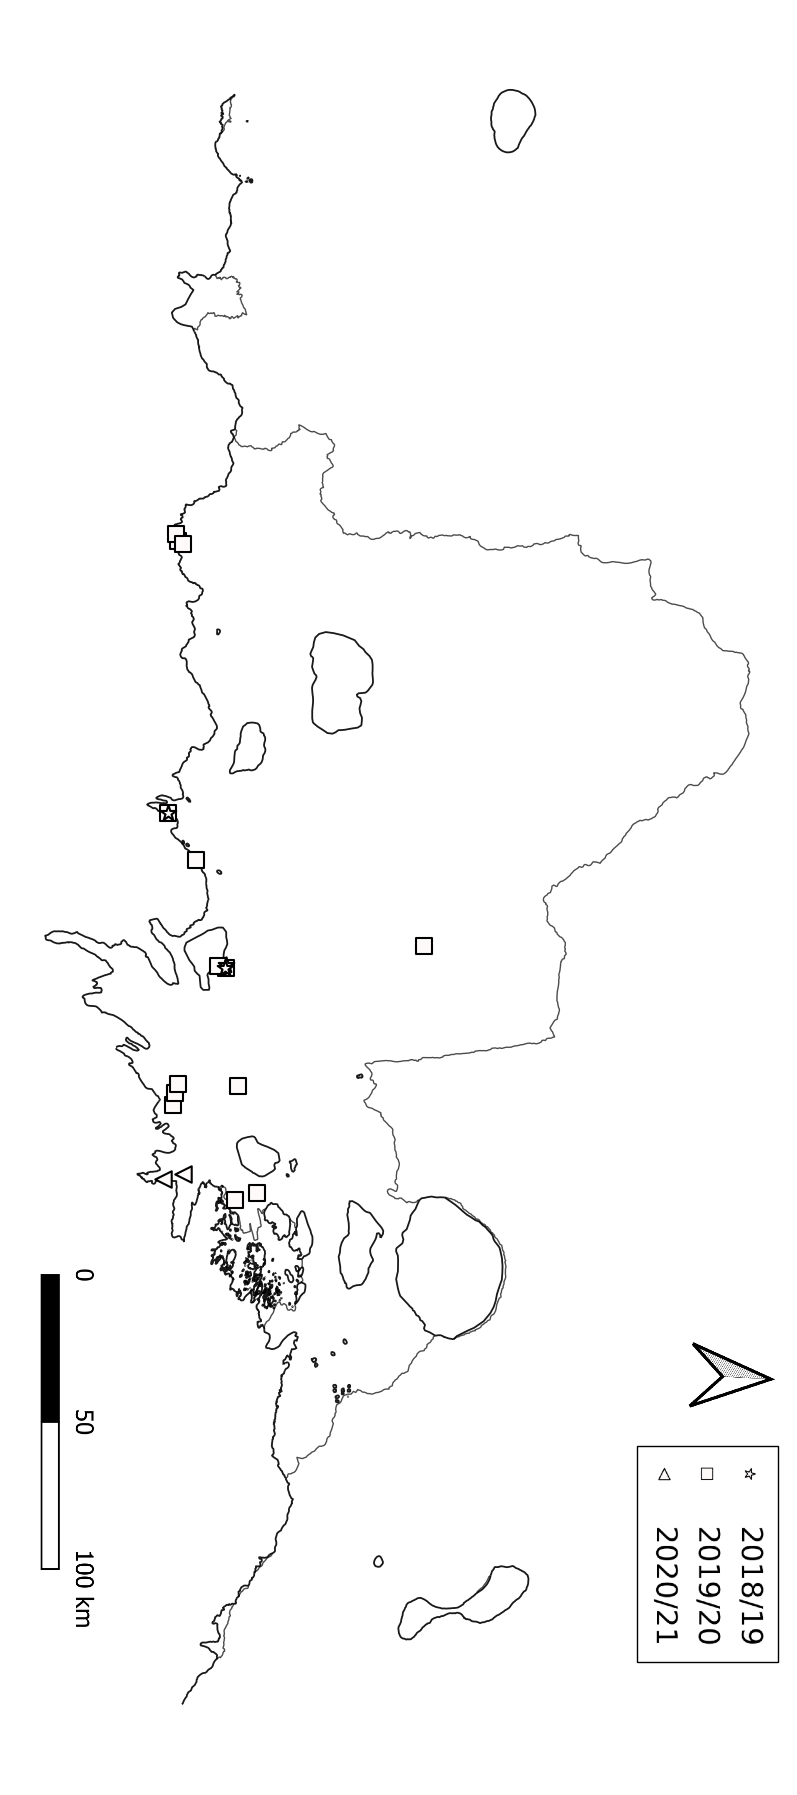

In [15]:
legend_box = OffsetImage(legend, zoom = 0.45)
legend_abox = AnnotationBbox(legend_box, xy = (0.9, 0.13), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.3)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.23), xycoords = 'axes fraction', frameon = False)
scale_box = OffsetImage(scale, zoom = 0.36)
scale_abox = AnnotationBbox(scale_box, xy = (0.08, 0.19), xycoords = 'axes fraction', frameon = False)

fig, ax = plt.subplots(figsize = (10, 30))
shelf.plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
solid.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)
cmap = cm.get_cmap('YlOrBr', 100)

"""lake extent"""
#lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.3)

"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")

ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale_abox)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

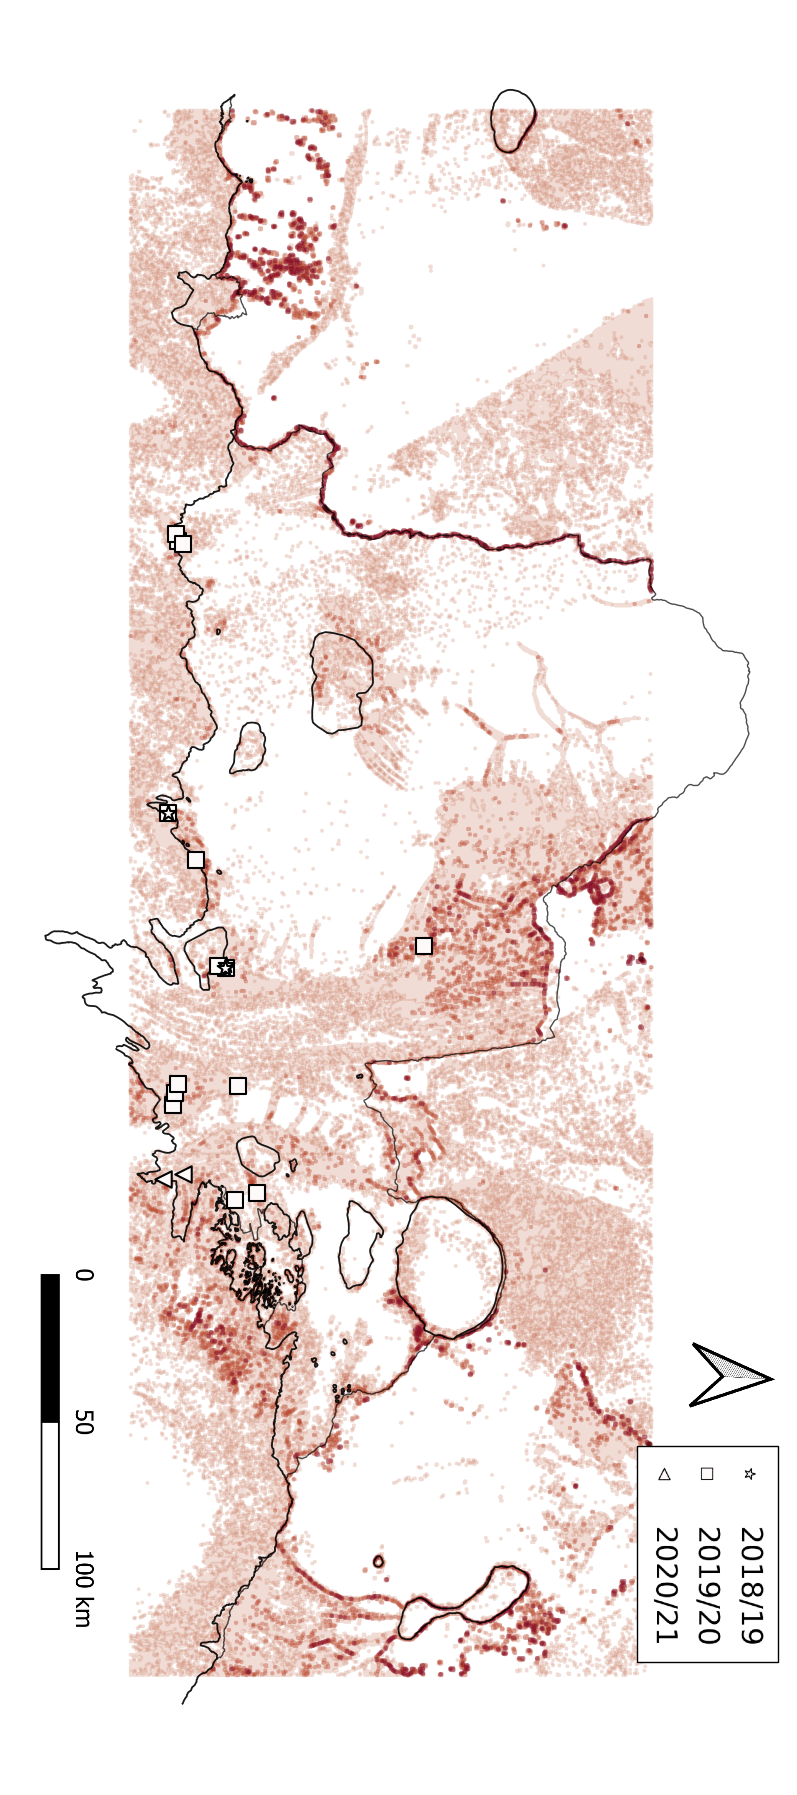

In [16]:
legend_box = OffsetImage(legend, zoom = 0.45)
legend_abox = AnnotationBbox(legend_box, xy = (0.9, 0.13), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.3)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.23), xycoords = 'axes fraction', frameon = False)
scale_box = OffsetImage(scale, zoom = 0.36)
scale_abox = AnnotationBbox(scale_box, xy = (0.08, 0.19), xycoords = 'axes fraction', frameon = False)

fig, ax = plt.subplots(figsize = (10, 30))
cmap = cmo.amp#cm.get_cmap('YlOrBr', 100)
shelf.plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
solid.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)
"""lake extent"""
#lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.3)

"""dmg"""
dmg_cats = sorted(dmgs["dmg"].unique())
for i_cat, cat in enumerate(dmg_cats):
    if i_cat == 0:
        pass#continue
    b = 400 + 300 * (i_cat + 1) / len(dmg_cats)
    dmgs[dmgs["dmg"] == cat].buffer(b).plot(ax = ax, alpha = 0.2 + 0.4 * (i_cat + 1) / len(dmg_cats), color = cmap(0.1 + 0.9 * (i_cat + 1) / len(dmg_cats)))

"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")

ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale_abox)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

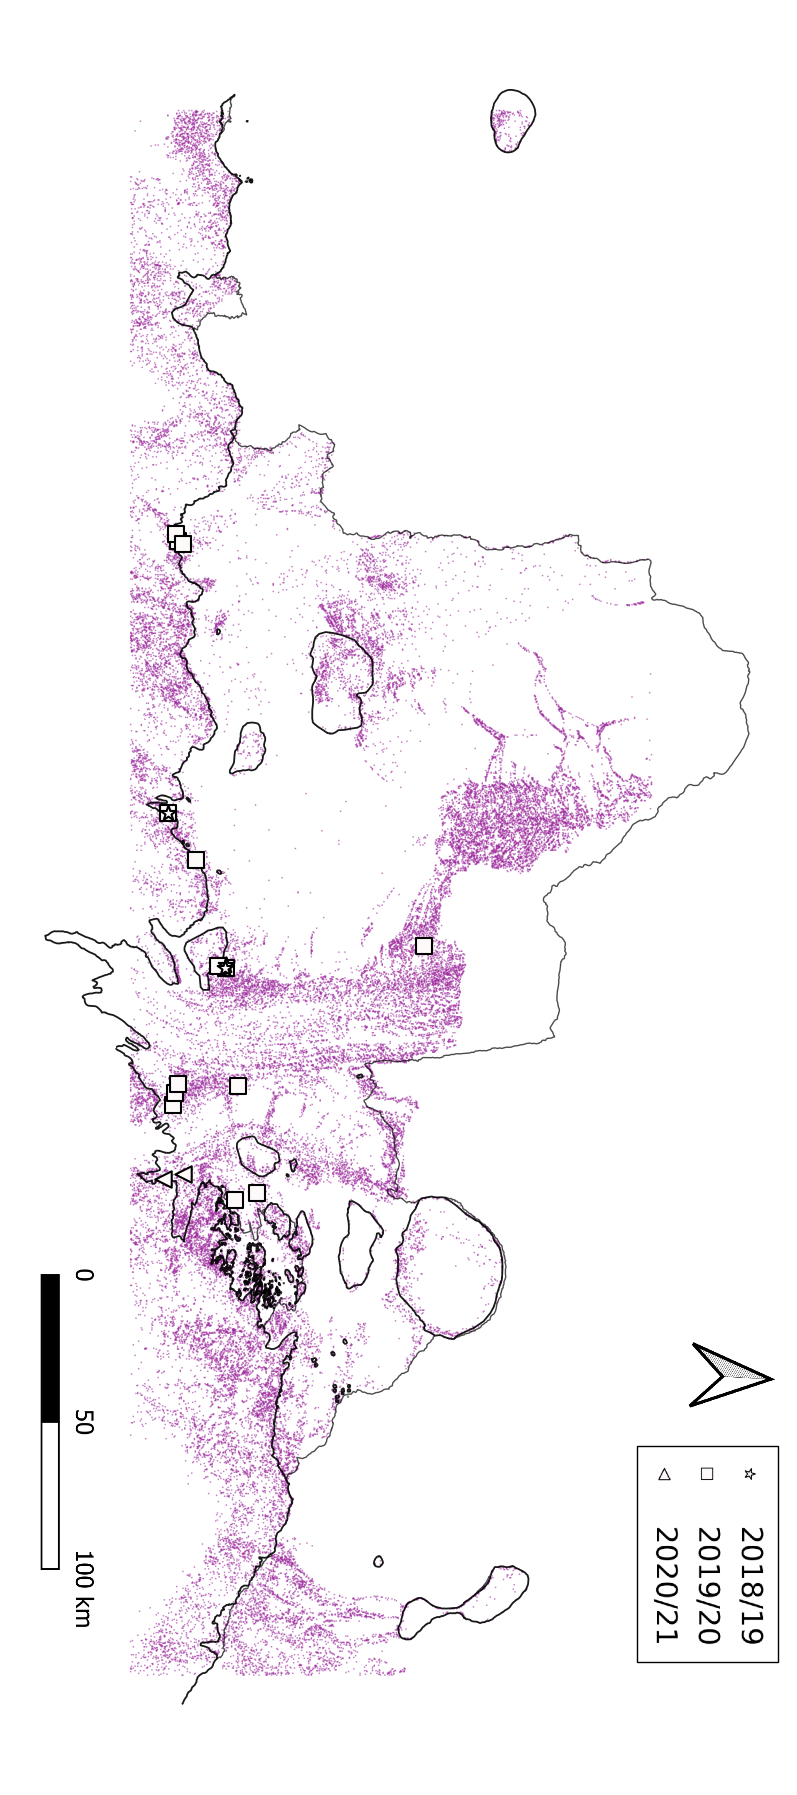

In [17]:
legend_box = OffsetImage(legend, zoom = 0.45)
legend_abox = AnnotationBbox(legend_box, xy = (0.9, 0.13), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.3)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.23), xycoords = 'axes fraction', frameon = False)
scale_box = OffsetImage(scale, zoom = 0.36)
scale_abox = AnnotationBbox(scale_box, xy = (0.08, 0.19), xycoords = 'axes fraction', frameon = False)

fig, ax = plt.subplots(figsize = (10, 30))
shelf.plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
solid.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)

"""lake extent"""
#lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.3)

"""active crevasses"""
crevs19.buffer(100).plot(ax = ax, alpha = 0.5, color = "darkmagenta")

   
"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")

ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale_abox)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

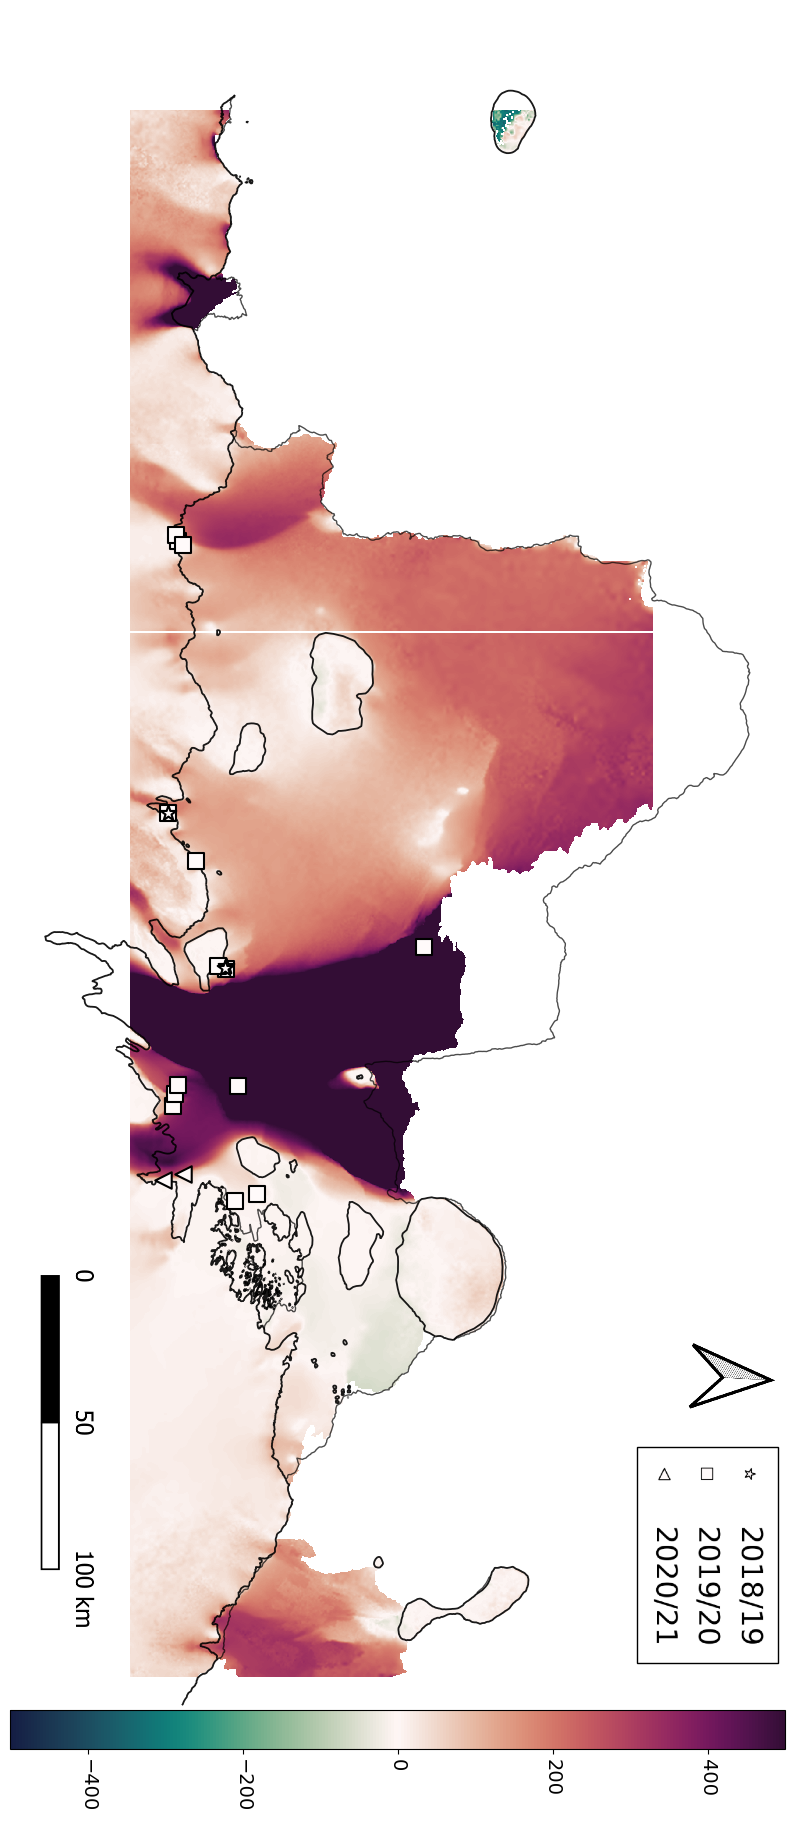

In [32]:
"""vx"""
vx_files_to_mosaic = []
for f in coll.vx_files:
    vx_files_to_mosaic.append(rasterio.open(os.path.join(settings.region_folder, f)))

with rasterio.open(os.path.join(settings.region_folder, coll.vx_files[0])) as src:
    meta = src.meta

vx_mosaic, vx_mosaic_transform = merge(vx_files_to_mosaic)

legend_box = OffsetImage(legend, zoom = 0.45)
legend_abox = AnnotationBbox(legend_box, xy = (0.9, 0.13), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.3)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.23), xycoords = 'axes fraction', frameon = False)
scale_box = OffsetImage(scale, zoom = 0.36)
scale_abox = AnnotationBbox(scale_box, xy = (0.08, 0.19), xycoords = 'axes fraction', frameon = False)

fig, ax = plt.subplots(figsize = (10, 30))
emax_base = ax.imshow(vx_mosaic[0], cmap = cmo.curl, vmin = -500, vmax = 500)
plt.close()


fig, ax = plt.subplots(figsize = (10, 30))
shelf.plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
solid.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)
rplt.show(vx_mosaic, transform = vx_mosaic_transform, ax = ax, cmap = cmo.curl, vmin = -500, vmax = 500)
#lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.15)

"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")

cbar = fig.colorbar(emax_base, ax=ax, fraction = 0.05, orientation = "horizontal", anchor = (1,6.5))
cbar.ax.tick_params(rotation=-90, labelsize=14)
ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale_abox)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

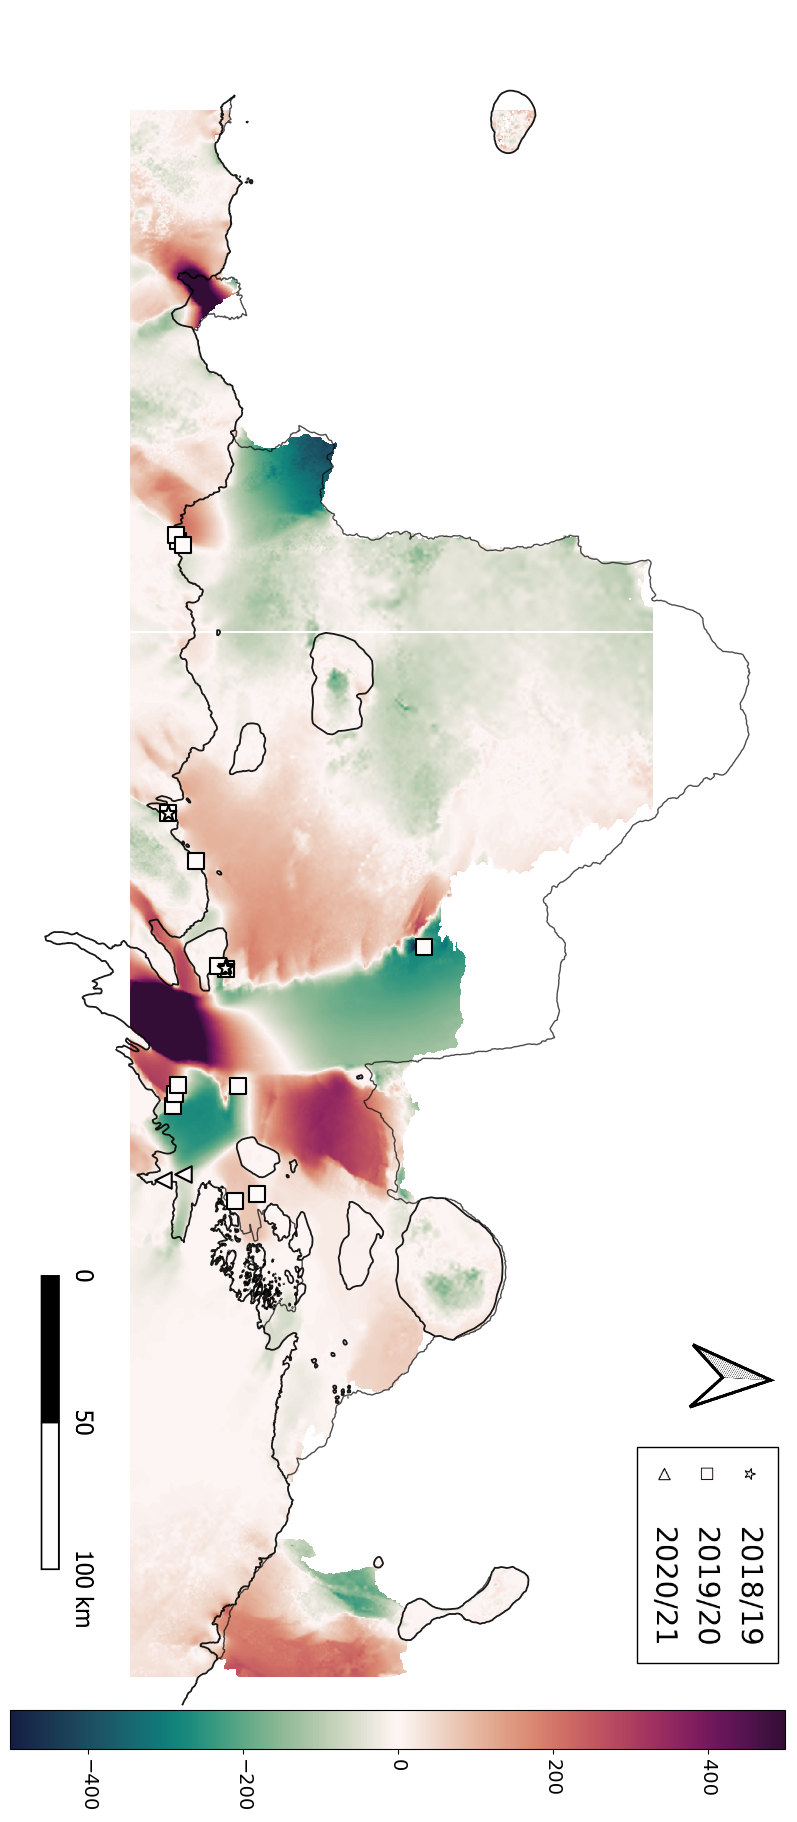

In [33]:
"""vy"""
vy_files_to_mosaic = []
for f in coll.vy_files:
    vy_files_to_mosaic.append(rasterio.open(os.path.join(settings.region_folder, f)))

with rasterio.open(os.path.join(settings.region_folder, coll.vy_files[0])) as src:
    meta = src.meta

vy_mosaic, vy_mosaic_transform = merge(vy_files_to_mosaic)

legend_box = OffsetImage(legend, zoom = 0.45)
legend_abox = AnnotationBbox(legend_box, xy = (0.9, 0.13), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.3)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.23), xycoords = 'axes fraction', frameon = False)
scale_box = OffsetImage(scale, zoom = 0.36)
scale_abox = AnnotationBbox(scale_box, xy = (0.08, 0.19), xycoords = 'axes fraction', frameon = False)

fig, ax = plt.subplots(figsize = (10, 30))
emax_base = ax.imshow(-vy_mosaic[0], cmap = cmo.curl, vmin = -500, vmax = 500)
plt.close()


fig, ax = plt.subplots(figsize = (10, 30))
shelf.plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
solid.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)
rplt.show(-vy_mosaic, transform = vy_mosaic_transform, ax = ax, cmap = cmo.curl, vmin = -500, vmax = 500)
#lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.15)

"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")

cbar = fig.colorbar(emax_base, ax=ax, fraction = 0.05, orientation = "horizontal", anchor = (1,6.5))
cbar.ax.tick_params(rotation=-90, labelsize=14)
ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale_abox)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

In [68]:
lakes = lakeextent19[lakeextent19.area > 54000]

In [70]:
def get_value(row, src):
    center = row["geometry"].centroid
    return [v for v in src.sample([(center.x, center.y)])][0][0]
lakes = lakeextent19[lakeextent19.area > 54000]
alldrains = pd.concat([drains18, drains19, drains20])
alldrains.apply(get_value, ,axis = 1)

In [72]:
def get_value(row, src):
    center = row["geometry"].centroid
    return [v for v in src.sample([(center.x, center.y)])][0][0]

TypeError: get_value() missing 1 required positional argument: 'src'